# Time Series Forecast Model Evaluation Using sktime
- Running several methods and comapring between them over a period of time

### Related Links:
- https://github.com/alan-turing-institute/sktime
- https://github.com/alan-turing-institute/sktime/blob/master/examples/01_forecasting.ipynb

### Packages - install if needed

## Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '14'

import numpy as np
import scipy as sp

import pandas as pd
import seaborn as sns
import random

#import ppscore as pps
#sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
from warnings import simplefilter

#import numpy as np
#import pandas as pd

#from sktime.datasets import load_airline
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
#%matplotlib inline

from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS
from sktime.forecasting.tbats import TBATS

from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.fbprophet import Prophet

In [4]:
import eda_utils as eda

In [5]:
import importlib
importlib.reload(eda);

In [6]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# Load Data - from file

In [7]:
filename = "nasdaq_stocks.csv"
data = pd.read_csv(filename)
print(data.shape)
data.head(5)

(808, 18)


,date,FB,GOOGL,AMZN,DELL,IBM,INTC,AAPL,MSFT,CSCO,ORCL,NVDA,VMW,HPQ,AMD,TSM,TXN,QCOM
0,2016-01-04,102.22,759.44,636.99,NaN,119.2253,31.0178,99.4989,51.0656,23.9163,34.1057,31.8157,46.7698,10.5034,2.770,20.1865,49.9251,44.2740
1,2016-01-05,102.73,761.53,633.79,NaN,119.1376,30.8718,97.0055,51.2986,23.8076,34.0008,32.3268,47.3679,10.6030,2.750,20.0586,49.4014,43.4083
2,2016-01-06,102.97,759.33,632.65,NaN,118.5413,30.1874,95.1072,50.3667,23.5541,34.1725,30.9901,45.8975,10.2227,2.505,19.5012,49.0798,42.9666
3,2016-01-07,97.92,741.00,607.94,NaN,116.5155,29.0558,91.0932,48.6148,23.0107,33.4284,29.7615,45.2911,9.7519,2.275,19.2818,47.4996,40.7582
4,2016-01-08,97.33,730.91,607.05,NaN,115.4368,28.7547,91.5749,48.7639,22.4402,33.0563,29.1226,44.9422,9.5798,2.140,19.0168,46.2684,40.5241


# Try to infer Dates automatically

In [8]:
data = eda.infer_date_col(data, timezone_conversion=False)
data.head(3)

col: date was transformed to date


,date,FB,GOOGL,AMZN,DELL,IBM,INTC,AAPL,MSFT,CSCO,ORCL,NVDA,VMW,HPQ,AMD,TSM,TXN,QCOM
0,2016-01-04,102.22,759.44,636.99,NaN,119.2253,31.0178,99.4989,51.0656,23.9163,34.1057,31.8157,46.7698,10.5034,2.770,20.1865,49.9251,44.2740
1,2016-01-05,102.73,761.53,633.79,NaN,119.1376,30.8718,97.0055,51.2986,23.8076,34.0008,32.3268,47.3679,10.6030,2.750,20.0586,49.4014,43.4083
2,2016-01-06,102.97,759.33,632.65,NaN,118.5413,30.1874,95.1072,50.3667,23.5541,34.1725,30.9901,45.8975,10.2227,2.505,19.5012,49.0798,42.9666


# Infer Frequency

In [9]:
col_date = "date"
max_date = data[col_date].max()
min_date = data[col_date].min()

rng = pd.date_range(start=min_date, end=max_date, periods=data.shape[0])
infered_freq = pd.infer_freq(rng, warn=True)
print("infered_freq:", infered_freq)

if infered_freq:
    rng_with_freq = pd.date_range(start=min_date, end=max_date, freq=infered_freq)
    if rng.shape[0] != rng_with_freq.shape[0]:
        print("There may be missing data")
    else:
        print("Infered frequency matches the number of observations")

infered_freq: None


In [10]:
rng

DatetimeIndex([          '2016-01-04 00:00:00',
               '2016-01-05 10:49:31.003717472',
               '2016-01-06 21:39:02.007434944',
               '2016-01-08 08:28:33.011152416',
               '2016-01-09 19:18:04.014869888',
               '2016-01-11 06:07:35.018587360',
               '2016-01-12 16:57:06.022304832',
               '2016-01-14 03:46:37.026022304',
               '2016-01-15 14:36:08.029739777',
               '2016-01-17 01:25:39.033457249',
               ...
               '2019-03-06 22:34:20.966542752',
               '2019-03-08 09:23:51.970260224',
               '2019-03-09 20:13:22.973977696',
               '2019-03-11 07:02:53.977695168',
               '2019-03-12 17:52:24.981412640',
               '2019-03-14 04:41:55.985130112',
               '2019-03-15 15:31:26.988847584',
               '2019-03-17 02:20:57.992565056',
               '2019-03-18 13:10:28.996282528',
                         '2019-03-20 00:00:00'],
              dtype=

In [11]:
col_date = "date"
data = data.sort_values(by=col_date)
data[col_date] = pd.to_datetime(data[col_date])
data = data.set_index(col_date)
data.head(3)

,FB,GOOGL,AMZN,DELL,IBM,INTC,AAPL,MSFT,CSCO,ORCL,NVDA,VMW,HPQ,AMD,TSM,TXN,QCOM
date,,,,,,,,,,,,,,,,,
2016-01-04,102.22,759.44,636.99,NaN,119.2253,31.0178,99.4989,51.0656,23.9163,34.1057,31.8157,46.7698,10.5034,2.770,20.1865,49.9251,44.2740
2016-01-05,102.73,761.53,633.79,NaN,119.1376,30.8718,97.0055,51.2986,23.8076,34.0008,32.3268,47.3679,10.6030,2.750,20.0586,49.4014,43.4083
2016-01-06,102.97,759.33,632.65,NaN,118.5413,30.1874,95.1072,50.3667,23.5541,34.1725,30.9901,45.8975,10.2227,2.505,19.5012,49.0798,42.9666


1172


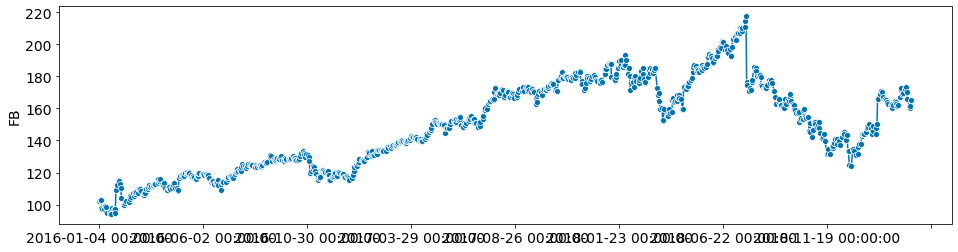

In [12]:
# Plotting
col = "FB"
series = data[col]
series = series.asfreq(freq='D')
print(series.shape[0])
plot_series(series);

# Model Evaluation

In [13]:
# - Choose mininmal train period
# - Go over all wanted models
#   - walk_forward_validation
#     - go over time series in intervals similar to production
#     - split to train and test, where train is for the known history and test is for the unknown
#     - predict future (using some specific method) and collect predictions or errors
#   - Calculate error over all test period and show results for each forecast method

## Functions

In [19]:
def code_transform_for_eval(code):
    # Transform multi line code to single line for eval function
    if '\n' not in code:
        return(code)
    code_as_list = code.split('\n')
    code_as_list_filtered = []
    for i in range(len(code_as_list)):
        line = code_as_list[i]
        if len(line)>0 and '#' not in line:
            code_as_list_filtered.append(line.strip())

    new_code = ''.join(code_as_list_filtered)        
    return(new_code)

def step_split_train_test(series, start_train_size, num_steps, step_size, forecast_horizon):
    # Split to train and test according to the number of steps we did
    train_size = start_train_size + num_steps * step_size
    test_size = forecast_horizon
    current_series_size = train_size + forecast_horizon
    current_series = series.head(current_series_size)
    series_train, series_test = temporal_train_test_split(current_series, test_size=test_size)
    return(series_train, series_test)

def forcaster_fit_and_predict(forcaster_name, series_train, series_test, fh, models_dict, loss_metric="smape"):
    
    if forcaster_name in models_dict:
        code_for_eval = code_transform_for_eval(models_dict[forcaster_name])
        forecaster = eval(code_for_eval)

    # forecaster fit
    # =====================================
    forecaster.fit(series_train)
    
    # forecaster predict
    # =====================================
    if forcaster_name=="Prophet": 
        series_pred = forecaster.predict(fh.to_relative(cutoff=series_train.index[-1]), return_pred_int=False)  
    else:
        series_pred = forecaster.predict(fh)
     
    # Collect errors
    # =====================================
    if loss_metric=="smape":
        current_smape_loss = smape_loss(series_pred, series_test)
        
    return(current_smape_loss)


# Basic step
def walk_forward_split_train_predict(series, start_train_size, forecast_horizon, step_size, model_to_use, models_dict, loss_metric="smape"):
    number_of_steps = int((series.shape[0] - start_train_size - step_size) / step_size)

    model_loss_per_step = []
    for num_steps in range(number_of_steps+1):

        # Split to train and test according to the number of steps we did
        series_train, series_test = step_split_train_test(series, start_train_size, num_steps, step_size, forecast_horizon)

        # Generating Forecast horizon
        fh = ForecastingHorizon(series_test.index, is_relative=False)

        # Using sktime last value for prediction
        current_smape_loss = forcaster_fit_and_predict(model_to_use, series_train, series_test, fh, models_dict, loss_metric)

        model_loss_per_step.append(current_smape_loss)

    return(model_loss_per_step)

# Run Evaluation on Univariate time series

In [20]:
col = "FB"
series = data[col]
series = series.asfreq(freq='D')

In [21]:
models_dict = {
    "NaiveForecaster": 'NaiveForecaster(strategy="last")',
    "NaiveForecaster_seasonal": 'NaiveForecaster(strategy="last", sp=7)',
    "ExponentialSmoothing": 'ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=7, use_boxcox=True)',
    "AutoETS": 'AutoETS(auto=True, sp=7, n_jobs=-1)',
    "AutoARIMA": 'AutoARIMA(sp=7, suppress_warnings=True)',
    "Arima001": 'ARIMA( order=(0, 1, 0), suppress_warnings=True)',
    "BATS": 'BATS(sp=1, use_trend=True, use_box_cox=False)',
    "TBATS": 'TBATS(sp=1, use_trend=True, use_box_cox=True)',
    "KNeighborsRegressor": 'ReducedRegressionForecaster(regressor=KNeighborsRegressor(n_neighbors=1), window_length=7, strategy="recursive")',
    "Prophet": 'Prophet(seasonality_mode="multiplicative", yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=False) ',    
    "TransformedTargetForecaster": '''
        TransformedTargetForecaster(
            [
                ("deseasonalise", Deseasonalizer(model="multiplicative", sp=7)),
                ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
                (
                    "forecast",
                    ReducedRegressionForecaster(
                        regressor=KNeighborsRegressor(n_neighbors=1), window_length=7, strategy="recursive"
                    ),
                ),
            ]
        )
        '''
    }   
        
models_to_use_list = ["NaiveForecaster", "NaiveForecaster_seasonal", 
                      "ExponentialSmoothing", 
                      #"AutoETS", "AutoARIMA", "Arima001", 
                      #"BATS", "TBATS",
                      "KNeighborsRegressor",
                      "TransformedTargetForecaster",
                      "Prophet",
                     ]
loss_metric="smape"

start_train_size = 7*150
forecast_horizon = 7
step_size = 7
series = series.fillna(method='ffill')
models_result = dict()
for i in range(len(models_to_use_list)):
    model_to_use = models_to_use_list[i]
    model_loss_per_step = walk_forward_split_train_predict(series, start_train_size, forecast_horizon, step_size, model_to_use, models_dict, loss_metric)
    models_result[model_to_use] = model_loss_per_step
    print(model_to_use, np.median(model_loss_per_step))
    
result_df = pd.DataFrame.from_dict(models_result)

NaiveForecaster 0.03286885017724609
NaiveForecaster_seasonal 0.039140412812943316
ExponentialSmoothing 0.03126723183463581
KNeighborsRegressor 0.035599914267350326
TransformedTargetForecaster 0.03442696514113317
Prophet 0.04023385002899119


<AxesSubplot:>

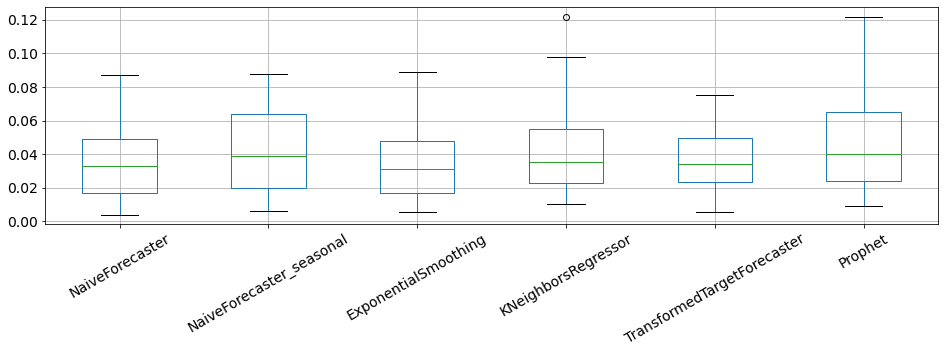

In [22]:
result_df.boxplot(rot=30, figsize=(16,4))

<AxesSubplot:>

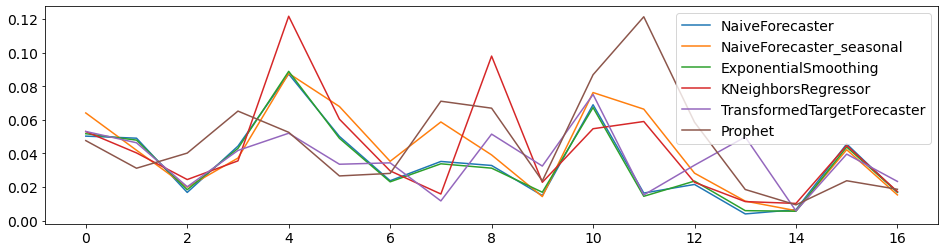

In [23]:
result_df.plot(figsize=(16,4))